In [15]:
'''
THIS NOTEBOOK CONTAINS ALL THE CODE FOR MODEL TRAINING. 
CHECK main.ipynb FOR DATASET CREATION
'''
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
import librosa


from src.dataset import get_dataloaders
from src.cvae import CVAE, vae_loss
from src.viz import plot_spectrograms
from inference import audio_to_spectrogram_transfer,play_audio_jupyter,convert_to_male_voice
from config import (
    DEVICE, 
    LATENT_DIM, 
    EMOTION_DIM, 
    LEARNING_RATE, 
    EPOCHS, 
    BETA,
    MODEL_DIR, 
    N_MELS,
    MAX_AUDIO_LENGTH,
    HOP_LENGTH,
    N_FFT,
    SAMPLE_RATE,
    EMOTION_CATEGORIES,
    GL_ITERS
)

In [22]:
WIN_LENGTH=N_FFT

In [24]:
import os
import zipfile

project_dir = '../DL_project'  
output_zip = 'my_project.zip'

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            ziph.write(file_path, 
                      os.path.relpath(file_path, 
                                     os.path.join(path, '..')))

with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(project_dir, zipf)
    
print(f"Created {output_zip} successfully")

OSError: [Errno 28] No space left on device

In [17]:
!pip install  pygame transformers librosa  TTS gtts pydub

In [18]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
print(f"Using device: {DEVICE}")

# Create dataloaders
train_loader, val_loader, dataset = get_dataloaders(use_cache=True)

# Calculate input dimensions from the dataset
time_frames = (MAX_AUDIO_LENGTH // HOP_LENGTH) + 1
input_dim = (N_MELS, time_frames)

In [ ]:
print(f"Number of batches in train_loader: {len(train_loader)}")

# Examine the first batch
for batch_idx, batch in enumerate(train_loader):
    print(f"Neutral specs shape: {batch['neutral_spec'].shape}")
    print(f"Emotion specs shape: {batch['emotion_spec'].shape}")
    print(f"Emotion labels shape: {batch['emotion_label'].shape}")
    
    # Check for NaN values
    print(f"Contains NaN in neutral: {torch.isnan(batch['neutral_spec']).any()}")
    print(f"Contains NaN in emotion: {torch.isnan(batch['emotion_spec']).any()}")
    
    # Check value ranges
    print(f"Neutral min: {batch['neutral_spec'].min()}, max: {batch['neutral_spec'].max()}")
    print(f"Emotion min: {batch['emotion_spec'].min()}, max: {batch['emotion_spec'].max()}")
    
    # Only check the first batch
    break

In [ ]:
input_dim

Input dimensions: (80, 216)
Starting epoch


Epoch 0: 100%|██████████| 212/212 [00:28<00:00,  7.36it/s, loss=10021.273438]

====> Epoch: 0 Average loss: 13053.086901


====> Validation set loss: 9828.293171
Model saved at epoch 0
Neutral specs shape: torch.Size([16, 1, 80, 216])
Reconstructed specs shape: torch.Size([16, 1, 80, 216])
(80, 216)


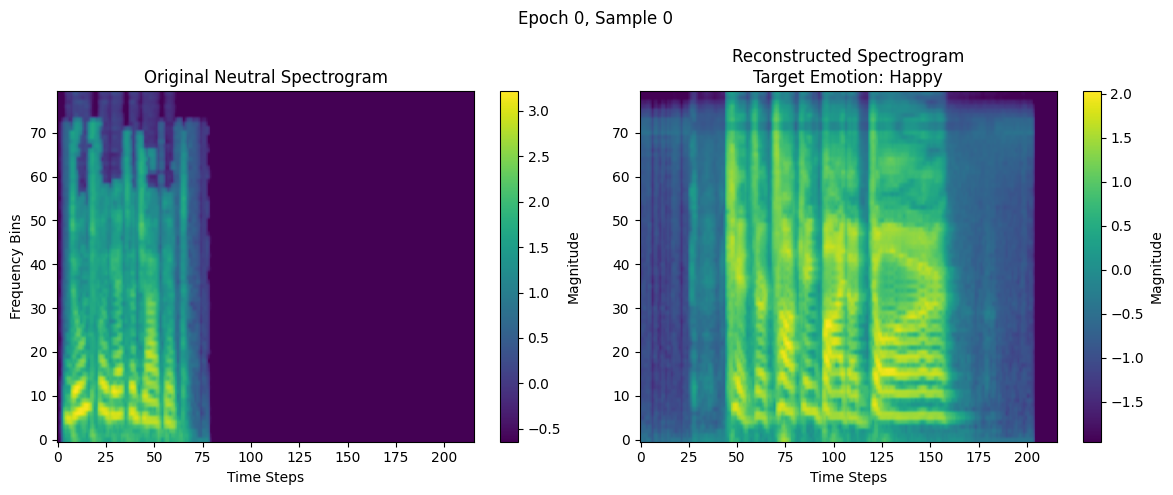

(80, 216)


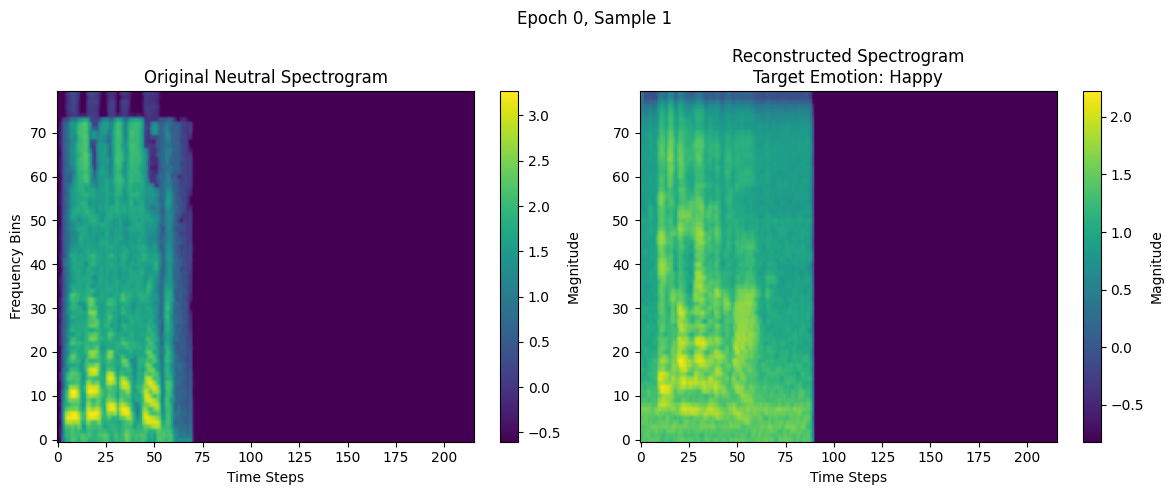

(80, 216)


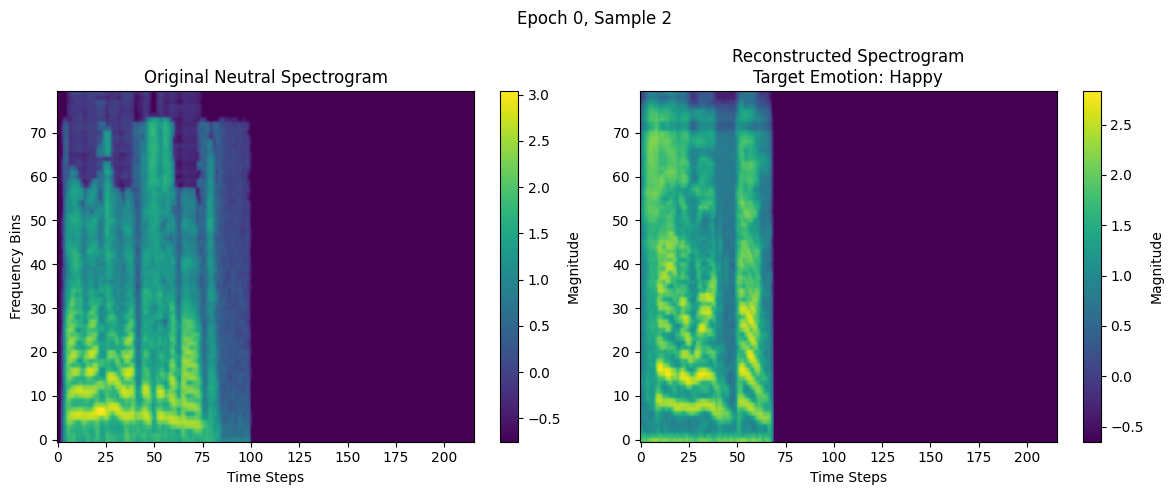

Starting epoch


Epoch 1: 100%|██████████| 212/212 [00:29<00:00,  7.25it/s, loss=7607.425223] 

====> Epoch: 1 Average loss: 8009.603890


====> Validation set loss: 7084.308944
Model saved at epoch 1
Starting epoch


Epoch 2: 100%|██████████| 212/212 [00:29<00:00,  7.24it/s, loss=5644.256138]

====> Epoch: 2 Average loss: 6350.469444


====> Validation set loss: 6276.277169
Model saved at epoch 2
Starting epoch


Epoch 3: 100%|██████████| 212/212 [00:29<00:00,  7.30it/s, loss=4378.950614]

====> Epoch: 3 Average loss: 5848.261538


====> Validation set loss: 6080.316627
Model saved at epoch 3
Starting epoch


Epoch 4: 100%|██████████| 212/212 [00:28<00:00,  7.44it/s, loss=4443.932199]

====> Epoch: 4 Average loss: 5666.605478


====> Validation set loss: 5943.562085
Model saved at epoch 4
Starting epoch


Epoch 5:  62%|██████▏   | 132/212 [00:18<00:11,  7.26it/s, loss=4592.531250]


KeyboardInterrupt: 

In [8]:
def init_weights(m):
    """Initialize model weights"""
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


def train_epoch(model, train_loader, optimizer, epoch, device):
    """Train model for one epoch"""
    from tqdm import tqdm
    
    model.train()
    train_loss = 0
    
    # Create progress bar
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, batch in enumerate(progress_bar):
        #print('Starting batch')
        neutral_spec = batch['neutral_spec'].to(device)
        emotion_spec = batch['emotion_spec'].to(device)
        
        emotion_label = batch['emotion_label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(neutral_spec, emotion_label)
        
        # Calculate loss
        loss = vae_loss(recon_batch, emotion_spec, mu, logvar, beta=BETA)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Update progress bar description with current loss
        progress_bar.set_postfix(loss=f'{loss.item()/len(neutral_spec):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.6f}')
    return avg_loss

def validate(model, val_loader, device):
    """Validate model"""
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            neutral_spec = batch['neutral_spec'].to(device)
            emotion_spec = batch['emotion_spec'].to(device)
            emotion_label = batch['emotion_label'].to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(neutral_spec, emotion_label)
            
            # Calculate loss
            loss = vae_loss(recon_batch, emotion_spec, mu, logvar, beta=BETA)
            val_loss += loss.item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    print(f'====> Validation set loss: {avg_loss:.6f}')
    return avg_loss

# Training complete
print(f"Input dimensions: {input_dim}")

# Initialize model
model = CVAE(input_dim=input_dim, latent_dim=LATENT_DIM, emotion_dim=EMOTION_DIM).to(DEVICE)
model.apply(init_weights)

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# For tracking metrics
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Training loop

start_time = time.time()
for epoch in range(0, EPOCHS + 1):
    # Train
    print('Starting epoch')
    train_loss = train_epoch(model, train_loader, optimizer, epoch, DEVICE)
    
    
    # Reconstruct with original emotion
    
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, DEVICE)
    val_losses.append(val_loss)
    
    # Save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_model.pth'))
        print(f"Model saved at epoch {epoch}")    
    
    # Visualize reconstructions
    if epoch % 30 == 0:
        model.eval()
        with torch.no_grad():
            # Get a batch from validation set
            val_batch = next(iter(val_loader))
            neutral_spec = val_batch['neutral_spec'].to(DEVICE)
            emotion_spec = val_batch['emotion_spec'].to(DEVICE)
            emotion_label = val_batch['emotion_label'].to(DEVICE)
            
            
            # Reconstruct with original emotion
            print(f"Neutral specs shape: {neutral_spec.shape}")
            recon_batch, _, _ = model(neutral_spec, emotion_label)
            print(f"Reconstructed specs shape: {recon_batch.shape}")
            
            
            # Plot a few examples
            for i in range(min(3, neutral_spec.size(0))):
                plot_spectrograms(
                    neutral_spec[i:i+1], 
                    emotion_spec[i:i+1], 
                    emotion_label[i], 
                    epoch, 
                    i
                )
            """
            for i in range(min(3, neutral_spec.size(0))):
                plot_spectrograms(
                    neutral_spec[i:i+1], 
                    recon_batch[i:i+1], 
                    emotion_label[i], 
                    epoch, 
                    i
                )
            """

# Training complete
print(f"Input dimensions: {input_dim}")



training_time = time.time() - start_time
print(f"Training completed in {training_time / 60:.2f} minutes")



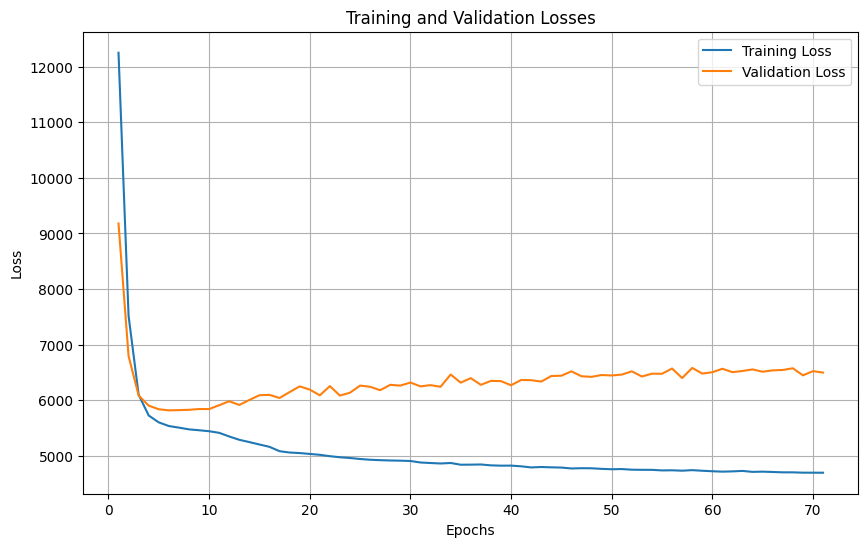

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(PLOT_OUTPUT_DIR, 'loss_plot.png'))
plt.show()

In [3]:
text="Hello! How are you!"

In [4]:
from gtts import gTTS
tts = gTTS(text=text, lang='en-in', slow=False, tld='co.in')
        
# Ensure output directory exists
output_dir = os.path.dirname('outputs')
input_mp3_file='outputs/input.mp3'
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save directly as MP3
tts.save(input_mp3_file)

In [5]:
from IPython.display import Audio

# Path to your MP3
mp3_path = "./outputs/input.mp3"

# Display an audio player
Audio(mp3_path)

In [6]:
convert_to_male_voice(mp3_path, "./outputs/input_modified.mp3")

True

In [7]:
from IPython.display import Audio

# Path to your MP3
mp3_path_modified = "./outputs/input_modified.mp3"

# Display an audio player
Audio(mp3_path)

In [8]:
emotion="Happy"
emotion=emotion+'_padded'
emotion_index = EMOTION_CATEGORIES.index(emotion)


model_path='./outputs/models/best_model.pth'
audio_path=mp3_path_modified



In [9]:
mel_spec_db,transformed_spec=audio_to_spectrogram_transfer(model_path=model_path,audio_path=audio_path, output_dir="./recon_check", emotion=emotion, sample_rate=SAMPLE_RATE,model=None)

Mel spectrogram shape: torch.Size([1, 80, 216])
Mel db shape: torch.Size([1, 80, 216])
Original Mel-spec dB shape: torch.Size([1, 1, 80, 216])
Transformed spec    shape: torch.Size([1, 1, 80, 216])
Min value: -100.0
Max value: 50.0
Min value: -100.0
Max value: 50.0
Saved reconstructed original to: ./outputs/recon_original.wav
Saved reconstructed transformed to: ./outputs/recon_Angry_padded.wav


/home/jovyan/teaching_material/DL project/inference.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed_spec=torch.tensor(transformed_spec).squeeze(0)


In [10]:
dataset_path = "./outputs"
file_name = "recon_Happy_padded.wav"
full_path = os.path.join(dataset_path, file_name)

play_audio_jupyter(full_path)

Playing: ./outputs/recon_Happy_padded.wav


In [11]:
dataset_path = "./outputs"
file_name = "recon_original.wav"
full_path = os.path.join(dataset_path, file_name)

play_audio_jupyter(full_path)

Playing: ./outputs/recon_original.wav


In [12]:
print("Min value:", mel_spec_db.min().item())
print("Max value:", mel_spec_db.max().item())


Min value: -0.6722022891044617
Max value: 3.2649548053741455


In [13]:
print("Min value:", transformed_spec.min().item())
print("Max value:", transformed_spec.max().item())


Min value: -1.3768914937973022
Max value: 1.6266793012619019


(80, 216)


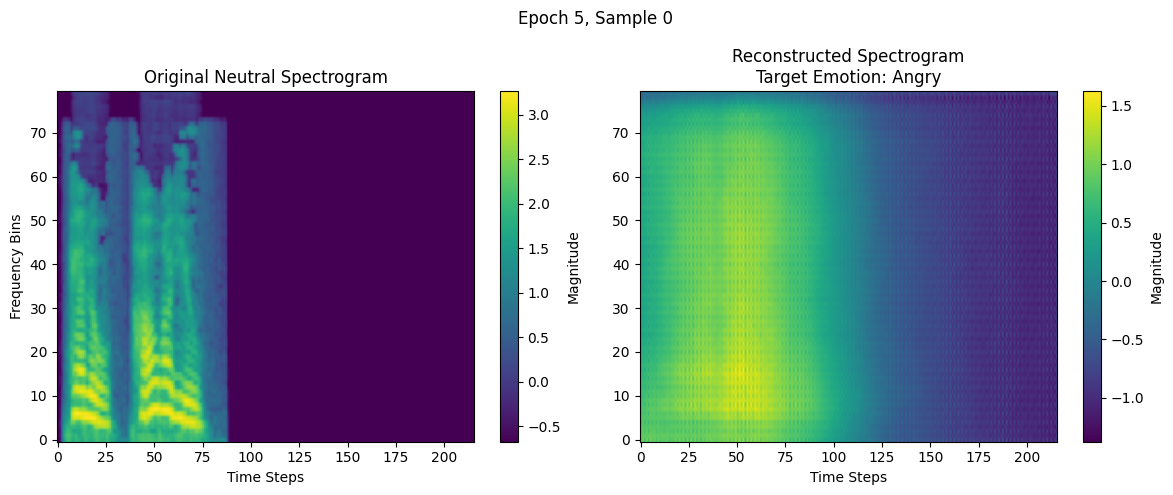

In [14]:
emotion_tensor = torch.zeros(EMOTION_DIM, device='cuda:0')
emotion_tensor[emotion_index] = 1.0
plot_spectrograms(
                    mel_spec_db, 
                    transformed_spec, 
                    emotion_tensor, 
                    5, 
                    0
                )